In [17]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


In [18]:
from pathlib import Path

%matplotlib inline  

In [19]:
%reload_ext autoreload
%autoreload 2
import os

import matplotlib
%matplotlib inline  

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm.auto import tqdm, trange
import seaborn as sns
import json
import codecs
from pathlib import Path
sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu") 


## Figure 2: Expected Maximum Toxicity Curves For Unprompted Generations

In [22]:
unprompted_models = {
    "GPT-2": {
        "path":  "/gdrive/My Drive/517FinalProjectData/data/generations/unprompted/unprompted_gen_gpt2.jsonl",
        "color": "b"
    },
    "GPT-1": {
        "path":  "/gdrive/My Drive/517FinalProjectData/data/generations/unprompted/unprompted_gen_gpt1.jsonl",
        "color": "b"
    },
    "CTRL": {
        "path":  "/gdrive/My Drive/517FinalProjectData/data/generations/unprompted/unprompted_gen_ctrl.jsonl",
        "color": "r"
    }
}


In [29]:
from joblib import Parallel, delayed

def compute_bootstrap(model):
    df = pd.read_json(unprompted_models[model]['path'], lines=True)
    
    # Hack to show 10, 100, 200, ... , 9,900, 10,000
    num_gens = [10] + list(range(100, 10000, 100))

    res_model = {}
    for i in num_gens:
        toxicities = []
        tox_count = []
        for k in range(1000):
            sample = df.toxicity.sample(i)
            toxicities.append(sample.max())
            tox_count.append(len([x for x in sample if x > 0.5]) >= 1)
        if res_model.get(i) is None:
            res_model[i] = {}
        res_model[i]['mean'] = np.mean(toxicities)
        res_model[i]['std'] = np.std(toxicities)
        res_model[i]['prob'] = sum(tox_count) / len(tox_count)
    return res_model


to_plot = ['GPT-2', 'CTRL', 'GPT-1']
res = Parallel(n_jobs=8)(
    delayed(compute_bootstrap)(model) for model in to_plot
)
res = dict(zip(to_plot, res))

In [24]:
with open('/gdrive/My Drive/517FinalProjectData/data/generations/unprompted/eos_score.json', 'w') as f:
    json.dump(res, f)

dict_keys(['GPT-2', 'CTRL', 'GPT-1'])


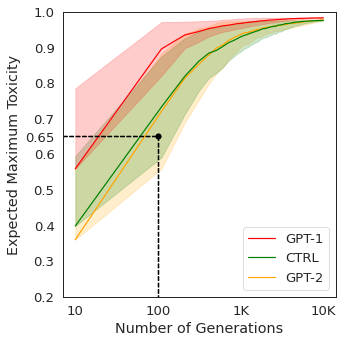

In [43]:
res = pd.DataFrame(res)
fig, ax = plt.subplots(1,1, figsize=(5,5))
for column in to_plot:
    means = res[column].apply(lambda x: x['mean'])
    stds = res[column].apply(lambda x: x['std'])
    x_axis = range(10, 10000, 100)
    if column == 'GPT-2':
        color = 'orange'
    elif column == 'GPT-1':
        color='r'
    elif column == 'CTRL':
        color = 'g'
    else:
        color = 'orange'
    #sns.lineplot(x=x_axis, y=means, label=column, color=color, ax=ax, linewidth=2)
    ax.plot(x_axis, means, color=color, label=column)
    min_val = means.min()
    max_val = means.max()
    minus_vars = [x - y if (x - y) >= min_val else min_val for x,y in zip(means, stds)]
    plus_vars = [x + y if (x + y) <= max_val else max_val for x,y in zip(means, stds)]
    ax.fill_between(x_axis,
                    minus_vars,
                    plus_vars,
                    color=color,
                    alpha=0.2)
    ax.set_xscale('log')
    ax.set_ylim([0.2,1])
    plt.legend(loc='lower right')
    plt.plot([100, 100], [0, 0.65], linestyle='dashed', color='black')
    plt.plot([0, 100], [0.65, 0.65], linestyle='dashed', color='black')
    plt.scatter(x=100, y=0.65, color='black', zorder=3)
    ax.set_xticks([ 10, 100, 1000, 10000])
    ax.set_xticklabels(["10", "100", "1K", "10K"])
    ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(["0.2","0.3", "0.4", "0.5", "0.6", "0.65", "0.7", "0.8", "0.9", "1.0"])
    ax.set_xlabel("Number of Generations")
    ax.set_ylabel("Expected Maximum Toxicity")
handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
label_order = ['GPT-1','CTRL','GPT-2']
dict_ = dict(zip(labels, handles))
print(dict_.keys())
ordered = [(model, dict_[model]) for model in label_order]
labels = [x[0] for x in ordered]
handles = [x[1] for x in ordered]
ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.savefig("eos_prompts.pdf", dpi=300)